# AI Project: Neural Network

#### Supervisors: Prof. Stéphane Marchand-Maillet, Assist. Vincent Micheli, Assist. Margarita Liarou

#### Students: CHRISTOFOROU Anthony Phillipous, VANSON Nathan Soufianus, WILLIAM Christian Athenaous, RASHIDI Massi Mohammedeous
---

In [1]:
# Libraries
import matplotlib
import numpy as np
import pandas as pd
from itertools import product
from ucimlrepo import fetch_ucirepo
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Modules
from ai_nn_project.utils.tuning import grid_search_knn, grid_search_mlp, parallel_grid_search_knn, parallel_grid_search_mlp
from ai_nn_project.models.neigbours.knn import KNN
from ai_nn_project.utils.visualisation import visualize_weights
from ai_nn_project.utils.activations import Sigmoid, ReLU, Linear
from ai_nn_project.models.neuronal_network.multilayer_perceptron import MLP
from ai_nn_project.utils.evaluations import accuracy, precision, recall, f1_score, mse_loss, mae_loss, rmse_loss, mape_loss, r2_score


# make figures appear inline
matplotlib.rcParams['figure.figsize'] = (15, 8)
%matplotlib inline

# notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

---

## Introduction

## Data Preprocessing

### Mushroom Dataset: Classification

In [2]:
# fetch dataset

# Mushroom. (1987). UCI Machine Learning Repository. https://doi.org/10.24432/C5959T.
mushroom = fetch_ucirepo(id=73) 

In [3]:
# pandas dataframe
mushroom_X = mushroom.data.features
mushroom_y = mushroom.data.targets

In [4]:
mushroom_X.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


In [5]:
mushroom_y.head()

,poisonous
0,p
1,e
2,e
3,p
4,e


In [6]:
# Encode categorical features as a one-hot numeric array: Gives a unique number to each category
le = LabelEncoder()

mushroom_X_encoded = mushroom_X.apply(le.fit_transform).to_numpy()
mushroom_y_encoded = mushroom_y.apply(le.fit_transform).to_numpy()

mushroom_X_train, mushroom_X_test, mushroom_y_train, mushroom_y_test = train_test_split(mushroom_X_encoded, mushroom_y_encoded, test_size=0.2, random_state=42)

### Wine Dataset: Regression

In [7]:
# Cortez,Paulo, Cerdeira,A., Almeida,F., Matos,T., and Reis,J.. (2009). Wine Quality. UCI Machine Learning Repository. https://doi.org/10.24432/C56S3T.
wine_quality = fetch_ucirepo(id=186)

In [8]:
wine_X = wine_quality.data.features
wine_y = wine_quality.data.targets

In [9]:
wine_X.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [10]:
wine_y.head()

,quality
0,5
1,5
2,5
3,6
4,5


In [11]:
scaler = StandardScaler()
wine_X_scaled = scaler.fit_transform(wine_X)
wine_y_scaled = wine_y.to_numpy()

wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(wine_X_scaled, wine_y_scaled, test_size=0.2, random_state=42)

## Hyperparameter Tuning

### Classification

### K-Nearest Neighbors

In [ ]:
param_grid = {
    'k': [3, 5, 7, 10, 15, 50, 100, 200],
}

fixed_params = {
    'mode': 'classification'
}

knn_best_param, knn_best_score, knn_results = parallel_grid_search_knn(accuracy, mushroom_X_train, mushroom_y_train, mushroom_X_test, mushroom_y_test, param_grid, fixed_params)

KNN Grid Search:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
print("Best parameter: ", knn_best_param)
print("Best score: ", knn_best_score)

Best parameter:  {'k': 3}
Best score:  0.9975384615384615


### Multi-Layer Perceptron

In [ ]:
layer_sizes_options = [32, 64, 128]
max_layers = 3  #exploring up to 3 hidden layers

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],  # List of learning rates to try
    'batch_size': [1, 8, 18],  # List of batch sizes to try
    'epochs': [32, 64],  # List of epochs to try
    'layer_sizes': [[mushroom_X_train.shape[1]] + list(combo) + [1] for num_layers in range(2, max_layers + 1) for combo in product(layer_sizes_options, repeat=num_layers)]
}

fixed_params = {
    'final_activation': Sigmoid(),
}

best_param, best_score, results = parallel_grid_search_mlp(accuracy, mushroom_X_train, mushroom_y_train, mushroom_X_test, mushroom_y_test, param_grid, fixed_params)

MLP Grid Search:   0%|          | 0/648 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/64 [00:00<?, ?it/s]


In [ ]:
print("Best parameter: ", best_param)
print("Best score: ", best_score)

Best parameter:  {'learning_rate': 0.1, 'batch_size': 1, 'epochs': 64, 'layer_sizes': [22, 128, 128, 64, 1], 'activation_objects': [<ai_nn_project.utils.activations.ReLU object at 0x7fbcb55d8cd0>, <ai_nn_project.utils.activations.ReLU object at 0x7fbcb55d8be0>, <ai_nn_project.utils.activations.ReLU object at 0x7fbcb55d84c0>, <ai_nn_project.utils.activations.Sigmoid object at 0x7fbcb55d84f0>]}
Best score:  0.9538461538461539


### Regression

### K-Nearest Neighbors

In [ ]:
param_grid = {
    'k': [3, 5, 7, 10, 15, 50, 100, 200],
}

fixed_params = {
    'mode': 'regression'
}

knn_best_param_reg, knn_best_score_reg, knn_results_reg = parallel_grid_search_knn(accuracy, wine_X_train, wine_y_train, wine_X_test, wine_y_test, param_grid, fixed_params)

KNN Grid Search:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
print("Best parameter: ", knn_best_param_reg)
print("Best score: ", knn_best_score_reg)

Best parameter:  {'k': 3}
Best score:  0.2823076923076923


### Multi-Layer Perceptron

In [ ]:
layer_sizes_options = [32, 64, 128]
max_layers = 3  #exploring up to 3 hidden layers

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],  # List of learning rates to try
    'batch_size': [1, 8, 16],  # List of batch sizes to try
    'epochs': [32, 64],  # List of epochs to try
    'layer_sizes': [[wine_X_train.shape[1]] + list(combo) + [1] for num_layers in range(2, max_layers + 1) for combo in product(layer_sizes_options, repeat=num_layers)]
}

fixed_params = {
    'final_activation': Linear(),
}

best_param_reg, best_score_reg, results_reg = parallel_grid_search_mlp(accuracy, wine_X_train, wine_y_train, wine_X_test, wine_y_test, param_grid, fixed_params)

MLP Grid Search:   0%|          | 0/648 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/32 [00:00<?, ?it/s]Training Progress:   0%|          | 0/32 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/32 [00:00<?, ?it/s]Training Progress:   0%|          | 0/32 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/64 [00:00<?, ?it/s]


In [ ]:
print("Best parameter: ", best_param_reg)
print("Best score: ", best_score_reg)

Best parameter:  {'learning_rate': 0.1, 'batch_size': 1, 'epochs': 64, 'layer_sizes': [11, 128, 128, 1], 'activation_objects': [<ai_nn_project.utils.activations.ReLU object at 0x7fbcb54751e0>, <ai_nn_project.utils.activations.ReLU object at 0x7fbcb54751b0>, <ai_nn_project.utils.activations.Linear object at 0x7fbcb5474520>]}
Best score:  0.5615384615384615


## Baseline K-Nearest Neighbors: Classification

In [ ]:
knn = KNN(**knn_best_param)
knn.fit(mushroom_X_train, mushroom_y_train)
mushroom_output = knn.predict(mushroom_X_test)

In [ ]:
mushroom_output = mushroom_output.reshape(-1, 1)

print("Accuracy: ", accuracy(mushroom_y_test, mushroom_output))
print("Precision: ", precision(mushroom_y_test, mushroom_output))
print("Recall: ", recall(mushroom_y_test, mushroom_output))
print("F1-Score: ", f1_score(mushroom_y_test, mushroom_output))

Accuracy:  0.9975384615384615
Precision:  0.9949109414758269
Recall:  1.0
F1-Score:  0.9974489795918366


## Multi-Layer Perceptron: Classification

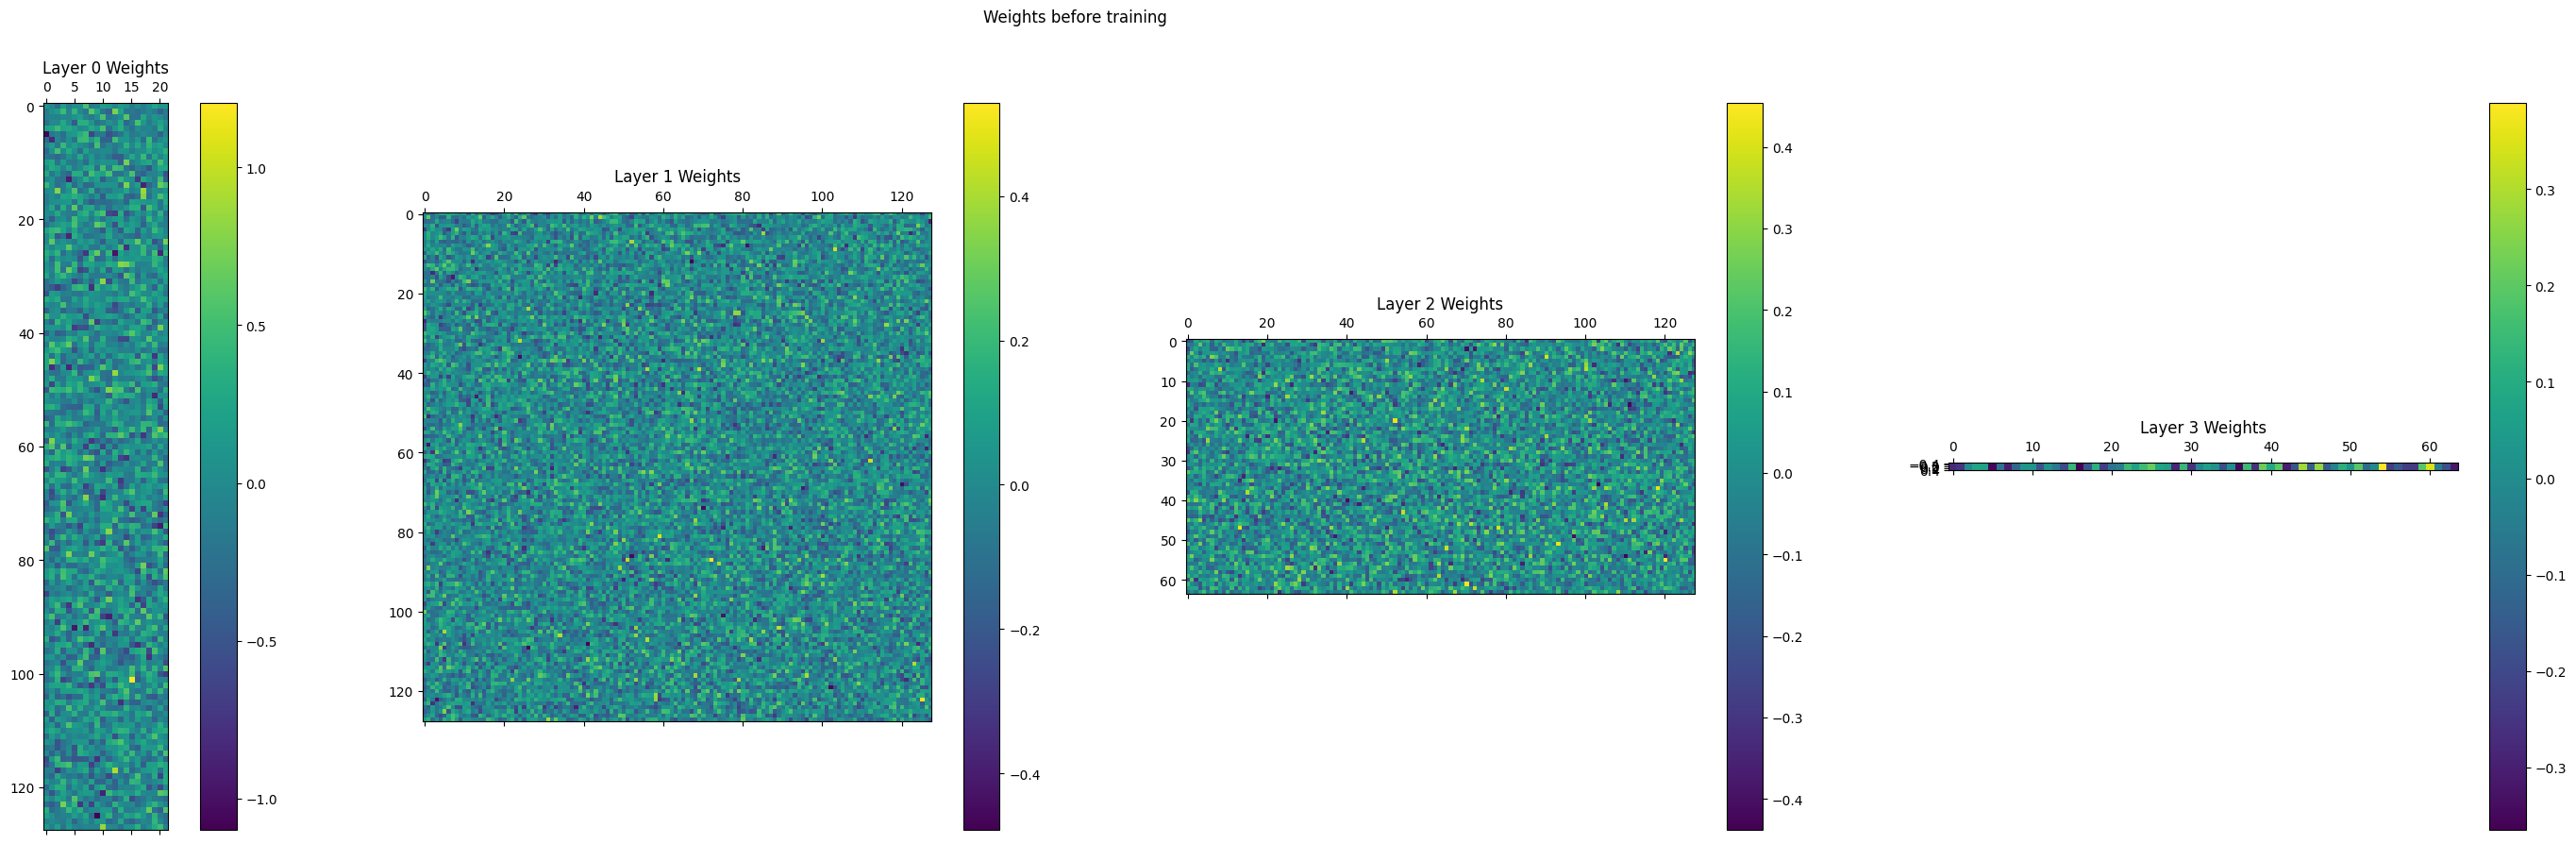

Training Progress:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1/64 - {'mse_loss': 0.17402424790752352}
Epoch 2/64 - {'mse_loss': 0.11310979443657654}
Epoch 3/64 - {'mse_loss': 0.09853030344138564}
Epoch 4/64 - {'mse_loss': 0.09186279280596306}
Epoch 5/64 - {'mse_loss': 0.08820367799098637}
Epoch 6/64 - {'mse_loss': 0.08520753952415337}
Epoch 7/64 - {'mse_loss': 0.08313210215676373}
Epoch 8/64 - {'mse_loss': 0.08130356773593721}
Epoch 9/64 - {'mse_loss': 0.07996251314483344}
Epoch 10/64 - {'mse_loss': 0.0785880522571127}
Epoch 11/64 - {'mse_loss': 0.0772861249018681}
Epoch 12/64 - {'mse_loss': 0.0755216198031971}
Epoch 13/64 - {'mse_loss': 0.07407254252018275}
Epoch 14/64 - {'mse_loss': 0.07277923380639763}
Epoch 15/64 - {'mse_loss': 0.07126273774614238}
Epoch 16/64 - {'mse_loss': 0.07021901071552188}
Epoch 17/64 - {'mse_loss': 0.06919439020214818}
Epoch 18/64 - {'mse_loss': 0.06795547360261521}
Epoch 19/64 - {'mse_loss': 0.0671661957189144}
Epoch 20/64 - {'mse_loss': 0.06569170988041875}
Epoch 21/64 - {'mse_loss': 0.0638539732936253}
Epoch 

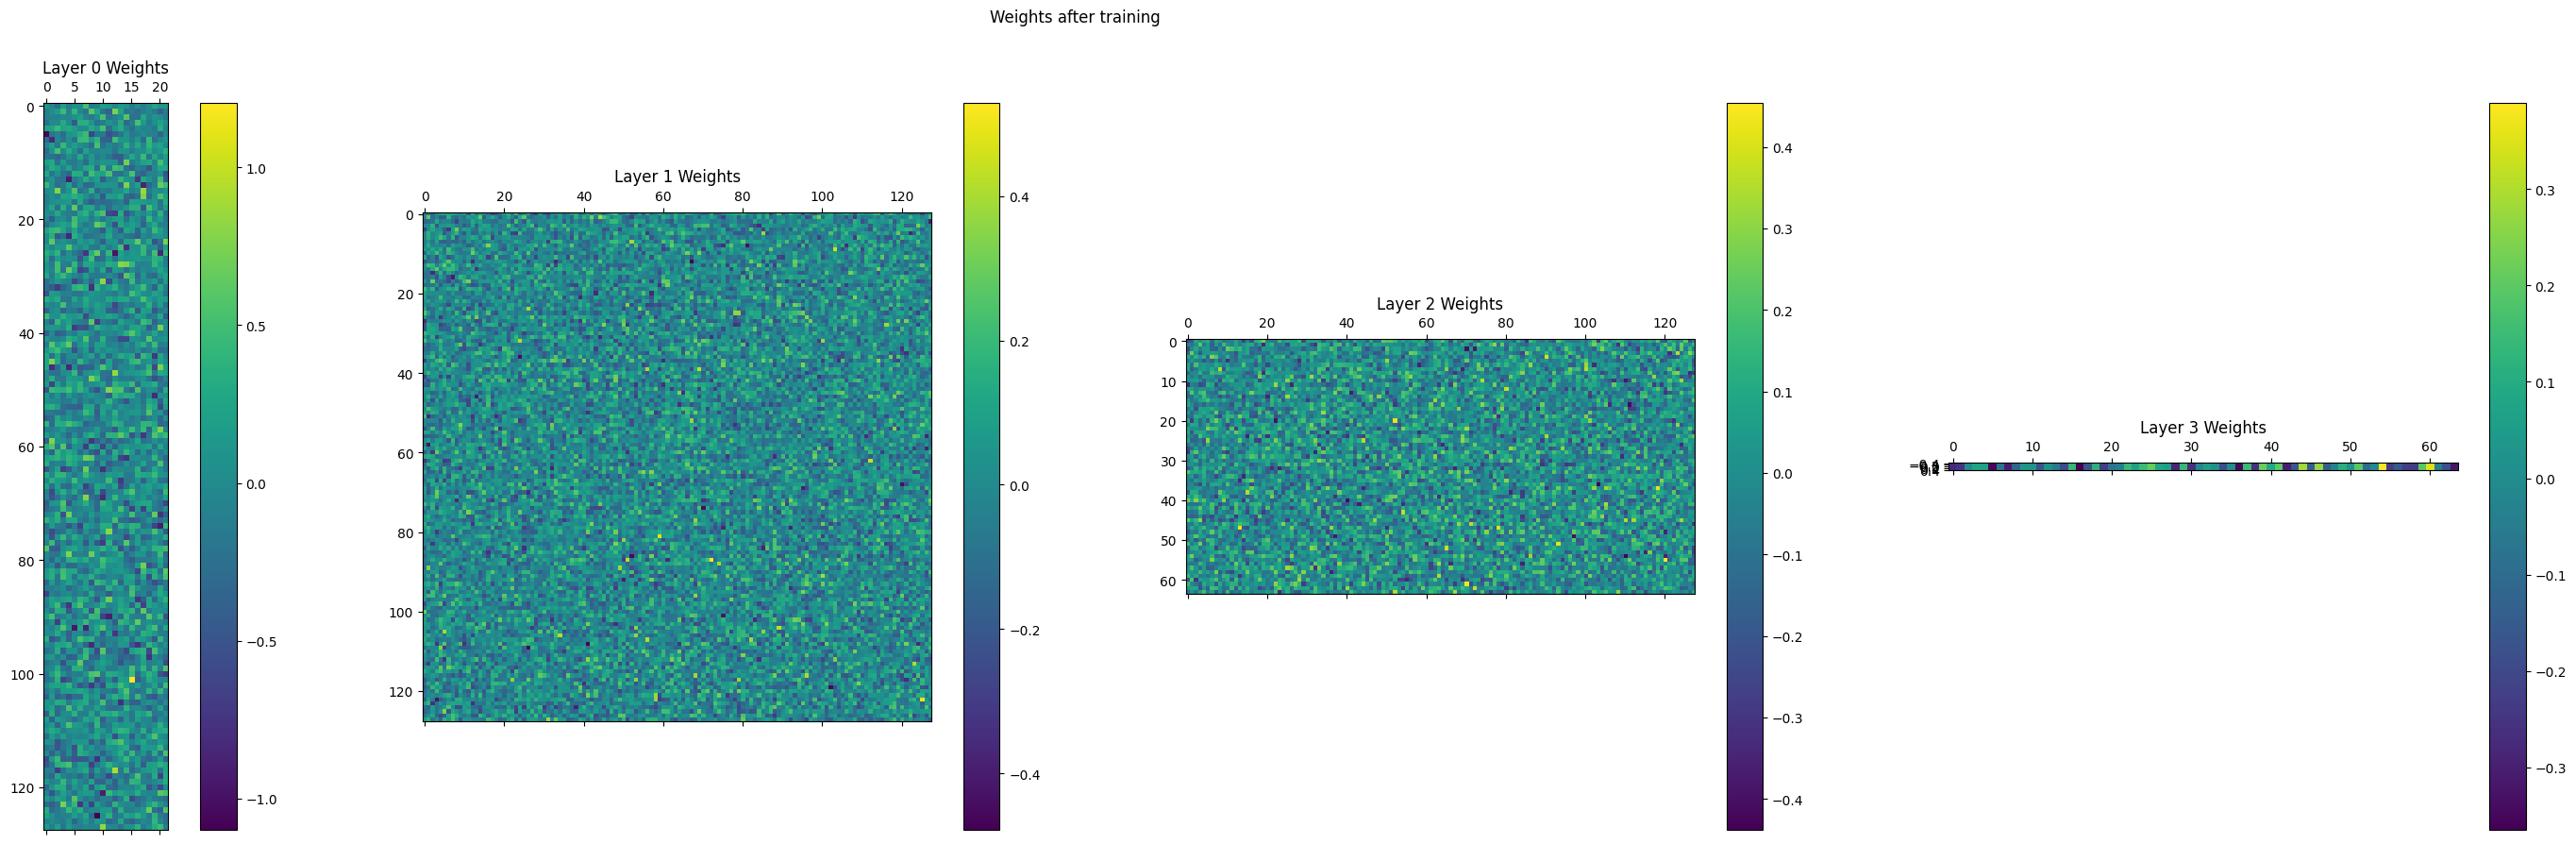

In [ ]:
mushroom_network = MLP(**best_param)

visualize_weights(mushroom_network, title="Weights before training")

metrics = mushroom_network.fit(mushroom_X_train, mushroom_y_train, verbose=True)

visualize_weights(mushroom_network, title="Weights after training")

In [ ]:
mushroom_output = mushroom_network.predict(mushroom_X_test.T)

# convert to binary
mushroom_output = np.where(mushroom_output >= 0.5, 1, 0)

print("Accuracy: ", accuracy(mushroom_y_test, mushroom_output.T))
print("Precision: ", precision(mushroom_y_test, mushroom_output.T))
print("Recall: ", recall(mushroom_y_test, mushroom_output.T))
print("F1-Score: ", f1_score(mushroom_y_test, mushroom_output.T))

Accuracy:  0.9316923076923077
Precision:  0.9539918809201624
Recall:  0.90153452685422
F1-Score:  0.9270216962524654


## Baseline K-Nearest Neighbors: Regression

In [ ]:
knn = KNN(**knn_best_param_reg)
knn.fit(wine_X_train, wine_y_train)
wine_output = knn.predict(wine_X_test) 

In [ ]:
wine_output = np.round(wine_output).reshape(-1, 1)

print("Accuracy: ", accuracy(wine_y_test, wine_output))
print("MSE: ", mse_loss(wine_y_test, wine_output))

Accuracy:  0.5392307692307692
MSE:  0.7838461538461539


## Multi-Layer Perceptron: Reggression

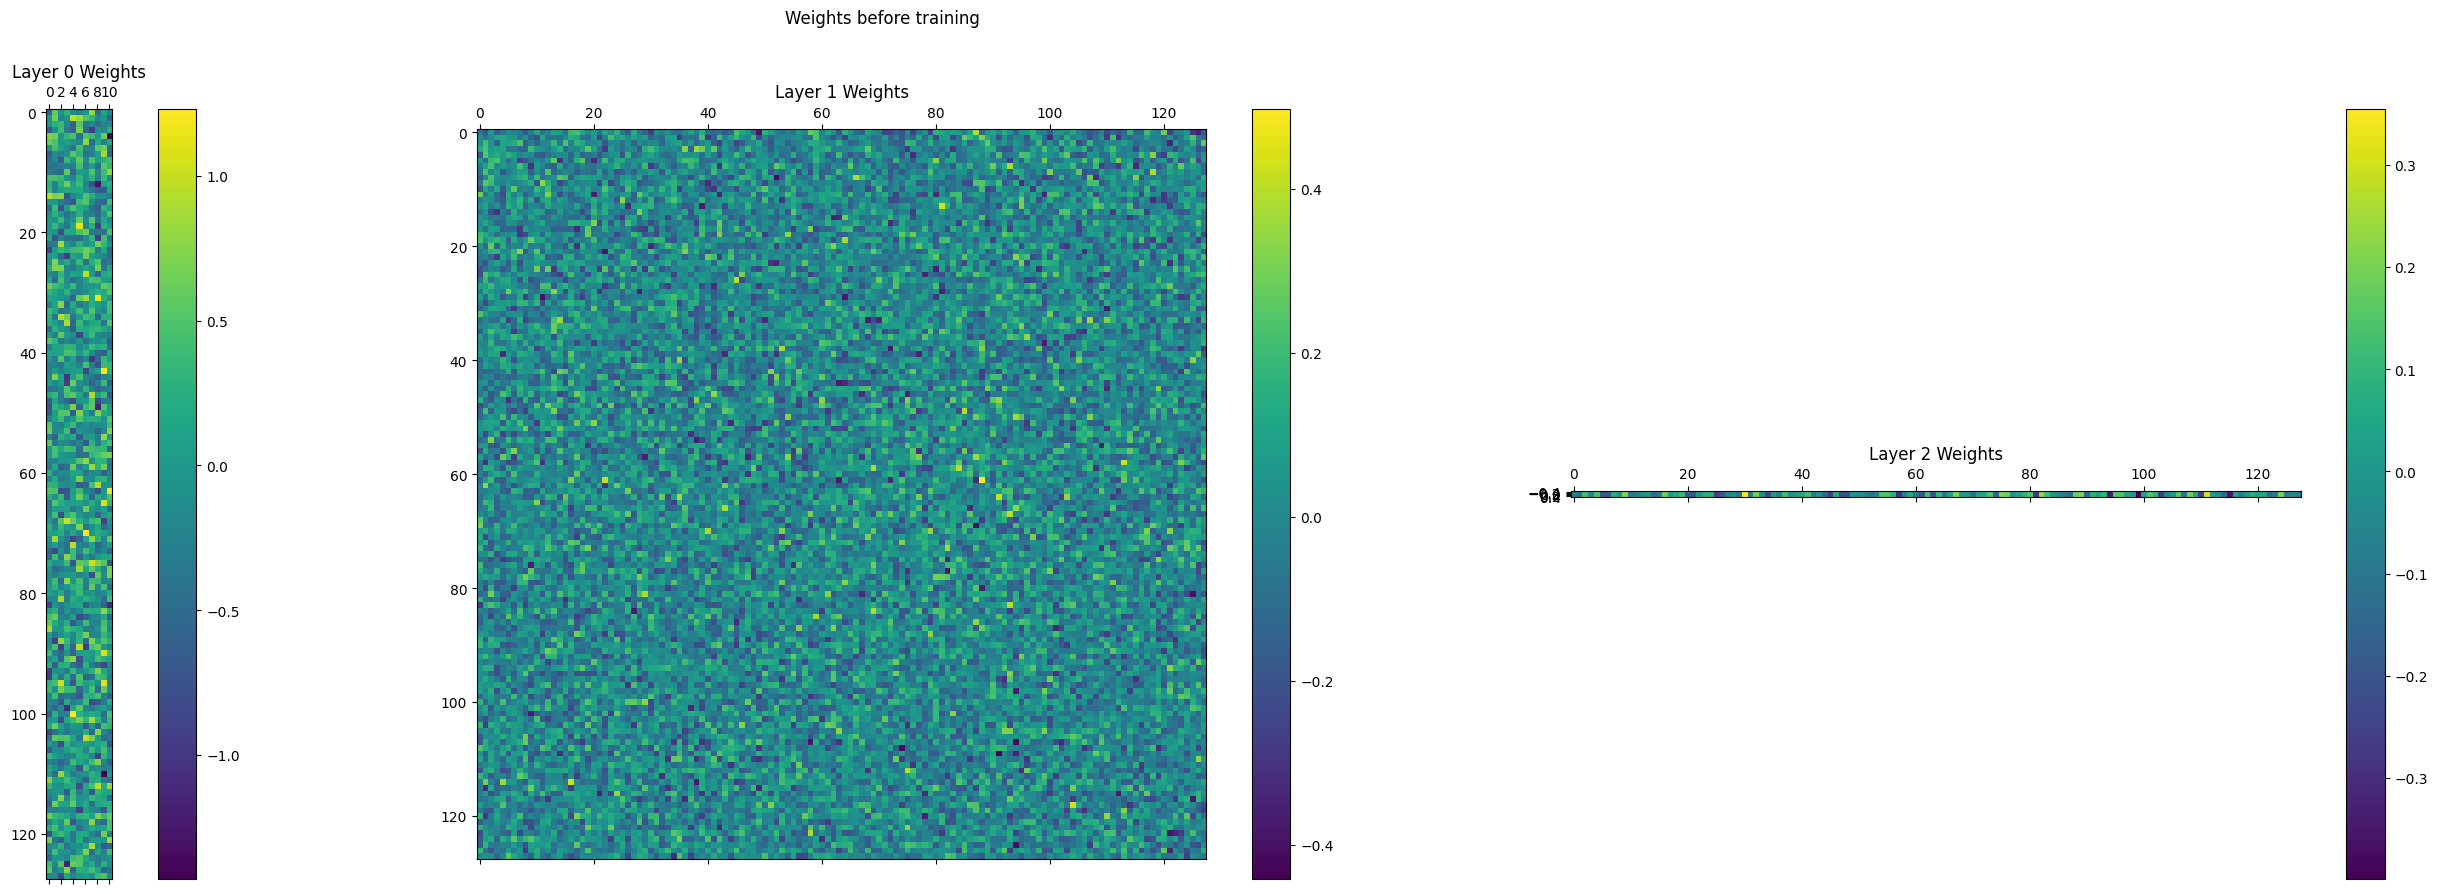

Training Progress:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1/64 - {'mse_loss': 0.8825003500094354}
Epoch 2/64 - {'mse_loss': 0.640589967928232}
Epoch 3/64 - {'mse_loss': 0.6014105685714343}
Epoch 4/64 - {'mse_loss': 0.5904577351705478}
Epoch 5/64 - {'mse_loss': 0.579071232340579}
Epoch 6/64 - {'mse_loss': 0.5720763630127529}
Epoch 7/64 - {'mse_loss': 0.5662348902354093}
Epoch 8/64 - {'mse_loss': 0.556408140840075}
Epoch 9/64 - {'mse_loss': 0.5611339959940865}
Epoch 10/64 - {'mse_loss': 0.5610374099803767}
Epoch 11/64 - {'mse_loss': 0.5509565995726735}
Epoch 12/64 - {'mse_loss': 0.549989333524604}
Epoch 13/64 - {'mse_loss': 0.551254575067582}
Epoch 14/64 - {'mse_loss': 0.5462341124064798}
Epoch 15/64 - {'mse_loss': 0.5462994571730366}
Epoch 16/64 - {'mse_loss': 0.548533572620165}
Epoch 17/64 - {'mse_loss': 0.5508404248754969}
Epoch 18/64 - {'mse_loss': 0.5463093538445694}
Epoch 19/64 - {'mse_loss': 0.5446470798916326}
Epoch 20/64 - {'mse_loss': 0.5406739065790828}
Epoch 21/64 - {'mse_loss': 0.5526669741954154}
Epoch 22/64 - {'mse_loss': 0

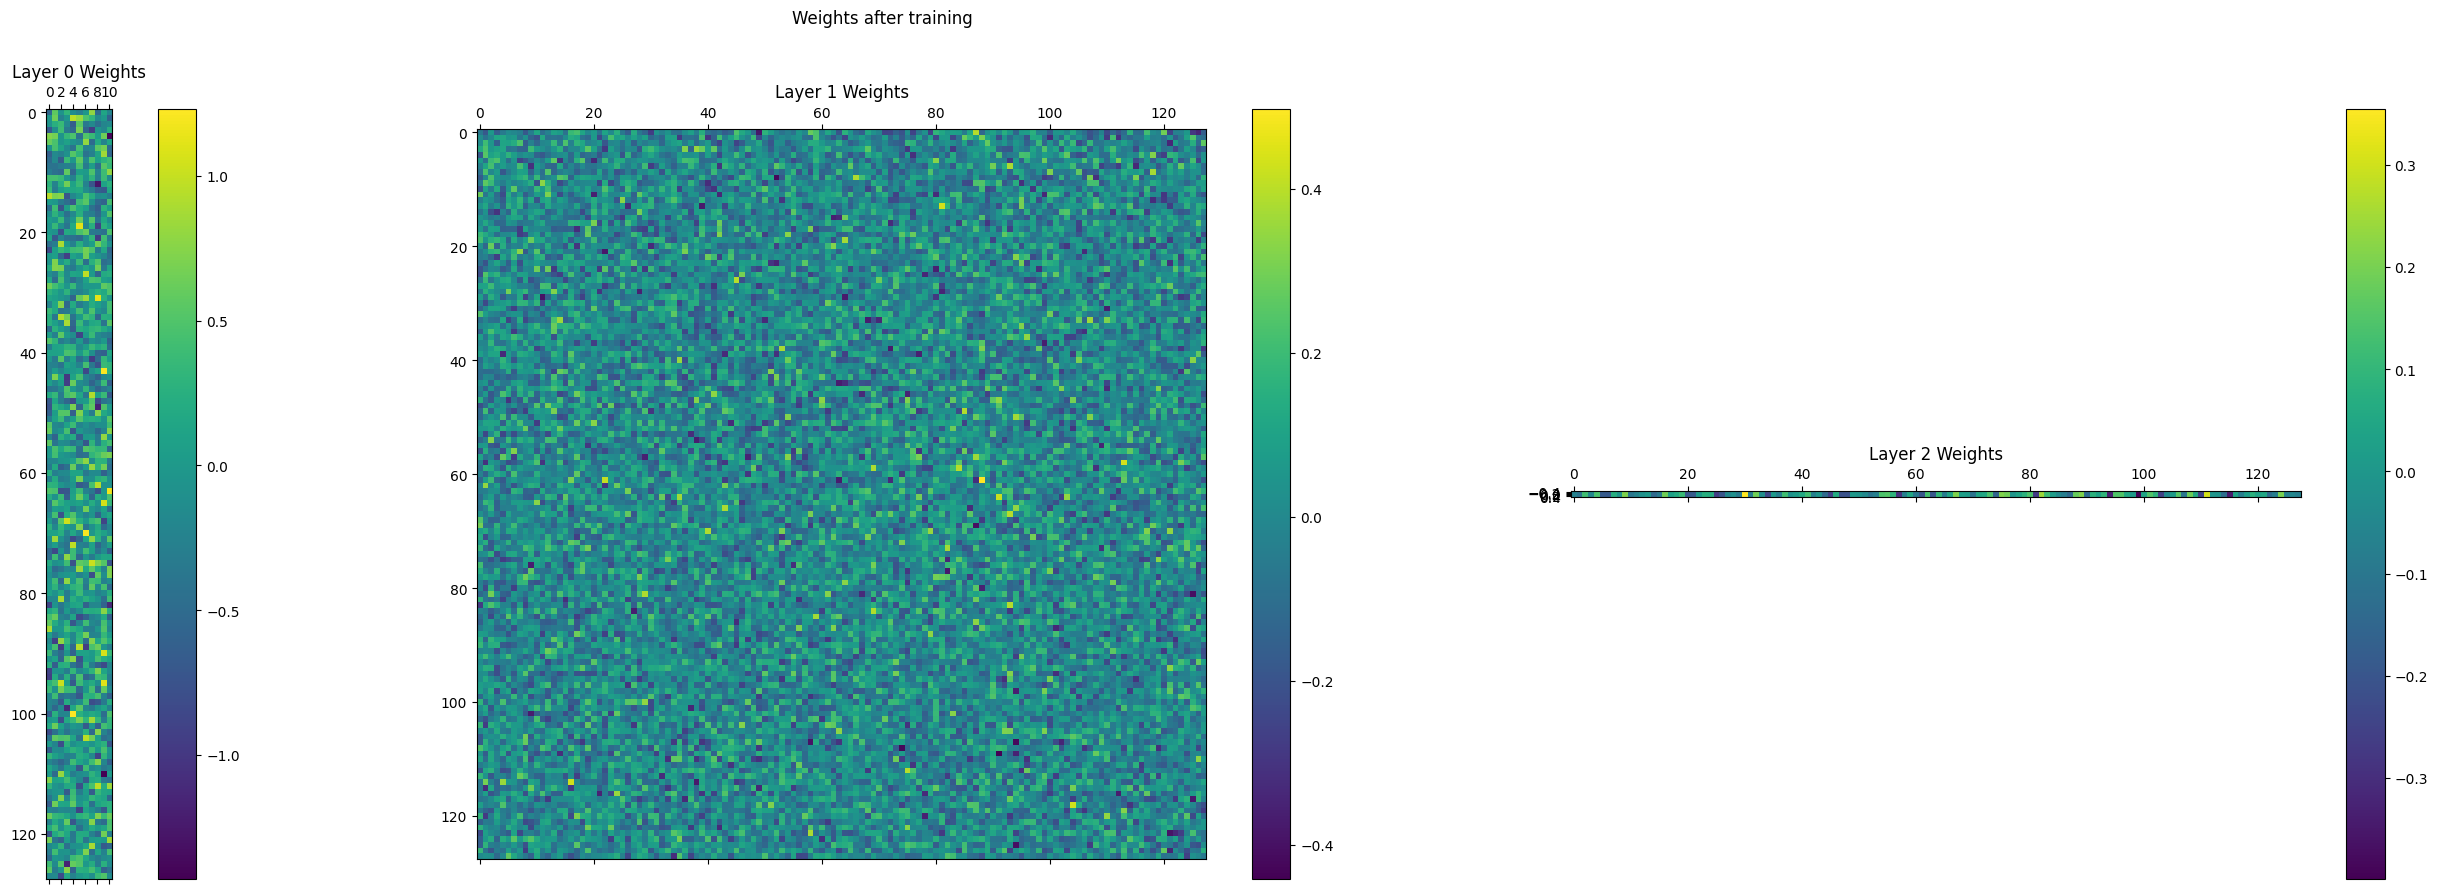

In [ ]:
mlp = MLP(**best_param_reg)

visualize_weights(mlp, title="Weights before training")

metrics = mlp.fit(wine_X_train, wine_y_train, verbose=True)

visualize_weights(mlp, title="Weights after training")

In [ ]:
wine_output = mlp.predict(wine_X_test.T) 
wine_output = np.round(wine_output)

print("Accuracy: ", accuracy(wine_y_test, wine_output.T))
print("MSE: ", mse_loss(wine_y_test, wine_output.T))
print("MAE: ", mae_loss(wine_y_test, wine_output.T))
print("RMSE: ", rmse_loss(wine_y_test, wine_output.T))
print("MAPE: ", mape_loss(wine_y_test, wine_output.T))
print("R2: ", r2_score(wine_y_test, wine_output.T))

Accuracy:  0.52
MSE:  0.62
MAE:  0.5246153846153846
RMSE:  0.7874007874011811
MAPE:  0.09596581196581196
R2:  0.16051353049007167


## Comparison with Other Models

### SKLearn MLP Classifier

In [ ]:
sklearn_mlp = MLPClassifier(hidden_layer_sizes=(128, 128), activation='relu', solver='adam', max_iter=1000, random_state=42)
sklearn_mlp.fit(mushroom_X_train, mushroom_y_train)

/home/hectellian/.cache/pypoetry/virtualenvs/ai-nn-project-46UtMOeQ-py3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=1000, random_state=42)

In [ ]:
sklearn_output = sklearn_mlp.predict(mushroom_X_test).reshape(-1, 1)

print("Accuracy: ", accuracy(mushroom_y_test, sklearn_output))
print("Precision: ", precision(mushroom_y_test, sklearn_output))
print("Recall: ", recall(mushroom_y_test, sklearn_output))
print("F1-Score: ", f1_score(mushroom_y_test, sklearn_output))

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1-Score:  1.0


### SKLearn MLP Regressor

In [ ]:
sklearn_mlp_reg = MLPRegressor(hidden_layer_sizes=(128, 128), activation='relu', solver='adam', max_iter=1000, random_state=42)
sklearn_mlp_reg.fit(wine_X_train, wine_y_train)

/home/hectellian/.cache/pypoetry/virtualenvs/ai-nn-project-46UtMOeQ-py3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(hidden_layer_sizes=(128, 128), max_iter=1000, random_state=42)

In [ ]:
sklearn_output_reg = sklearn_mlp_reg.predict(wine_X_test).reshape(-1, 1)
sklearn_output_reg = np.round(sklearn_output_reg)

print("Accuracy: ", accuracy(wine_y_test, sklearn_output_reg))
print("MSE: ", mse_loss(wine_y_test, sklearn_output_reg))
print("MAE: ", mae_loss(wine_y_test, sklearn_output_reg))
print("RMSE: ", rmse_loss(wine_y_test, sklearn_output_reg))
print("MAPE: ", mape_loss(wine_y_test, sklearn_output_reg))
print("R2: ", r2_score(wine_y_test, sklearn_output_reg))

Accuracy:  0.5884615384615385
MSE:  0.566923076923077
MAE:  0.46076923076923076
RMSE:  0.7529429440024503
MAPE:  0.08157112332112333
R2:  0.2323802381776462
